In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import svd, norm

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

C:\Users\Panos\Anaconda3\envs\python37_full\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
filename = "data.xlsx"

X_train = pd.read_excel(filename, sheet_name="azip", header=None)
y_train = pd.read_excel(filename, sheet_name="dzip", header=None)
X_test = pd.read_excel(filename, sheet_name="testzip", header=None)
y_test = pd.read_excel(filename, sheet_name="dtest", header=None)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test).T, np.array(y_test).T

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((256, 1707), (1, 1707), (2007, 256), (2007, 1))

Below we define the Svd_Classifier Class, which contains the main functionalities needed.

In [4]:
class Svd_Classifier():
    
    def init(self):
        # The truncated U matrix for each digit
        self.U = {}
        # The truncated S vector for each digit
        self.S = {}
        # The optimal number of basis vectors in terms of accuracy (to be tuned)
        self.best_num_of_bv = 5

    
    def split_training_set_per_digit(self, X_train, y_train):
        train = {digit: X_train[:, np.where(y_train==digit)[1]] for digit in range(10)}
        return train
    
    
    def fit_svd(self, X, n_components, trunc_level={}):
        '''
        param trunc_level is a dictionary used for the 3rd Task where 
        we truncate further the singular vector of digit 1 
        '''
        Uk_matrices, Sk_vectors = {}, {}

        for digit in range(10):
                
            # Here we only store the first n_components of the U and S matrices
            U, S, _ = svd(train[digit], check_finite=False)
            Uk_matrices[digit] = U[:, :n_components] if digit not in trunc_level.keys() else U[:, :trunc_level[digit]]
            Sk_vectors[digit] = S[:n_components] if digit not in trunc_level.keys() else U[:, :trunc_level[digit]]

        self.U = Uk_matrices
        self.S = Sk_vectors
    
    
    def norm_of_resid_vector_ls(self, digit, test_example, use_one_sing_vec=False):
        '''
        the norm of the relative residual vector of the LS problem
        param use_one_sing_vec is used for the optional task; if True we 
        calculate the norm with regards to only the first singular vector
        '''
        if use_one_sing_vec:
            return norm((np.identity(256) - (self.U[digit][:, 0].reshape(-1, 1) @ \
                    self.U[digit][:, 0].reshape(-1, 1).T)) @ test_example) / norm(test_example)
        else:    
            return norm((np.identity(256) - (self.U[digit] @ self.U[digit].T)) @ test_example) / norm(test_example)
    
    
    def predict(self, X_test, two_stage=False, thres_for_two_stage=0.1):
        '''
        param two_stage is used for the optional task; if True we compare only
        the first singular vector of each class at first and if the difference
        is smaller than a threshold, we continue as in the case of one-stage
        predictions, else we classify as that class giving the smallest residual
        '''
        if two_stage:
            count = 0
        preds = []
        
        for test_example in X_test:
            norms = {}
            
            if two_stage:
                for digit in range(10):
                    norms[digit] = self.norm_of_resid_vector_ls(digit, test_example, use_one_sing_vec=True)
                
                sorted_norms = sorted(norms.items(), key=lambda v: v[1])
                if sorted_norms[1][1] - sorted_norms[0][1] > thres_for_two_stage:
                    preds.append(sorted_norms[0][0])
                    count += 1
                    continue
                else:
                    for digit in range(10):
                        norms[digit] = self.norm_of_resid_vector_ls(digit, test_example)
                
                    preds.append(min(norms, key=lambda x: norms[x]))
                
            else:
                for digit in range(10):
                    norms[digit] = self.norm_of_resid_vector_ls(digit, test_example)
                
                preds.append(min(norms, key=lambda x: norms[x]))
        
        if two_stage:
            print("For threshold={}, the second stage was unnecessary {:.0f} % of the time." \
                  .format(thres_for_two_stage, count/len(X_test)*100))
        
        return preds
    
    
    def tune(self, train, X_test, y_test, min_basis_vec, max_basis_vec, autofit=True, trunc_level={}):
        '''
        param trunc_level is a dictionary used for the 3rd Task where 
        we truncate further the singular vector of digit 1 
        
        param autofit is used to fit the model according to the optimal number
        of basis vectors after the tuning is complete
        '''
        acc_scores = {}
        
        for basis_vector in range(min_basis_vec, max_basis_vec + 1):
            self.fit_svd(train, basis_vector, trunc_level)
            
            preds = self.predict(X_test)
            acc = accuracy_score(y_true=y_test, y_pred=preds)
            acc_scores[basis_vector] = acc
            
        self.best_num_of_bv = max(acc_scores, key=lambda x: acc_scores[x])
        
        if autofit:
            self.fit_svd(train, self.best_num_of_bv, trunc_level)
        
        return acc_scores
    
    
    def plot_tuning_results(self, acc_scores):
        plt.figure(figsize=(14, 7))
        plt.xlabel("# of Basis Vectors")
        plt.ylabel("Accuracy")
        _ = plt.plot(list(acc_scores.keys()), list(acc_scores.values()), marker='x')


## Task 1

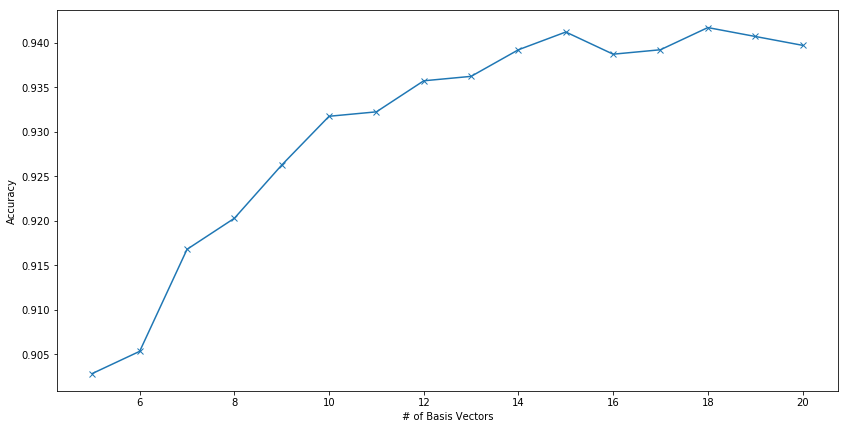

In [5]:
svd_clf = Svd_Classifier()

train = svd_clf.split_training_set_per_digit(X_train, y_train)

acc_scores = svd_clf.tune(train, X_test, y_test, 5, 20)

svd_clf.plot_tuning_results(acc_scores)

In [6]:
pd.DataFrame(data=list(acc_scores.items()), columns=['# of Basis Vectors', 'Accuracy'])

,# of Basis Vectors,Accuracy
0,5,0.902840
1,6,0.905331
2,7,0.916791
3,8,0.920279
4,9,0.926258
5,10,0.931739
6,11,0.932237
7,12,0.935725
8,13,0.936223
9,14,0.939213


In [7]:
print("Optimal number of Basis Vectors: {}, with Accuracy: {:.0f}%" \
      .format(svd_clf.best_num_of_bv, acc_scores[svd_clf.best_num_of_bv] * 100))

Optimal number of Basis Vectors: 18, with Accuracy: 94%


## Task 2

In [8]:
preds = svd_clf.predict(X_test)

In [9]:
print("Confusion Matrix:\n\n", confusion_matrix(y_true=y_test, y_pred=preds))

Confusion Matrix:

 [[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 178   2   5   0   0   1   3   0]
 [  2   0   3 150   1   6   0   1   2   1]
 [  2   1   0   0 185   2   0   3   0   7]
 [  7   1   1   5   0 141   0   0   2   3]
 [  2   1   0   0   2   1 163   0   1   0]
 [  0   1   1   0   3   0   0 141   0   1]
 [  2   0   1   6   0   1   0   0 153   3]
 [  0   2   0   1   4   0   0   3   2 165]]


In [10]:
print("Classification Report:\n\n", classification_report(y_true=y_test, y_pred=preds))

Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       0.97      0.98      0.98       264
           2       0.96      0.90      0.93       198
           3       0.91      0.90      0.91       166
           4       0.91      0.93      0.92       200
           5       0.93      0.88      0.91       160
           6       0.99      0.96      0.97       170
           7       0.95      0.96      0.95       147
           8       0.94      0.92      0.93       166
           9       0.91      0.93      0.92       177

   micro avg       0.94      0.94      0.94      2007
   macro avg       0.94      0.94      0.94      2007
weighted avg       0.94      0.94      0.94      2007



Below, we define a function which plots some misclassified examples, in order to observe if there were badly written. We utilize the `to_image()` function so as to be able to plot an image.

In [24]:
def to_image(X):
    X = X.reshape(16, 16)
    plt.imshow(X, cmap="gray")

def plot_misclassified_images(num=16):
    '''
    Note: num parameter should have an integer square root in order to
    have the capability to plot the figures
    '''
    assert np.sqrt(num)**2 == num
    
    plt.figure(figsize=(12, 6))
    
    # Next we utilize np.where so as to get only the misclassified test examples
    for i, ind in enumerate(np.where(y_test.reshape(-1,) != preds)[0][:num]):
        plt.subplot(np.sqrt(num), np.sqrt(num), i+1)
        to_image(X_test[ind])
    plt.show()

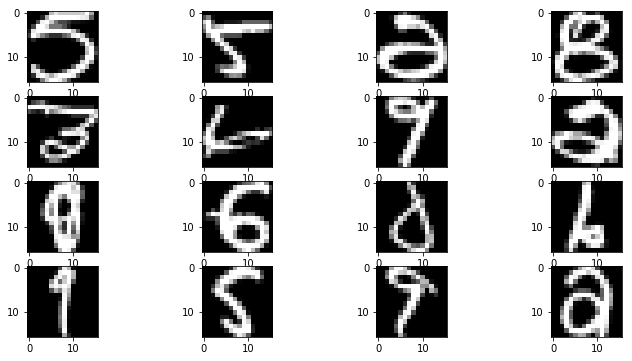

In [25]:
plot_misclassified_images()

## Task 3

In [13]:
# Let's have a look at the singular values
print("Singular values of each class:")
svd_clf.S

Singular values of each class:


{0: array([ 184.44749844,   97.59388422,   62.05061337,   54.14931248,
          41.06020067,   40.36847138,   36.28294233,   30.02308652,
          29.00107349,   24.94954536,   23.14227656,   20.02945118,
          19.87091668,   19.04653739,   18.36025675,   17.83522812,
          17.52693996,   16.69341498]),
 1: array([ 234.04151731,   41.9309063 ,   24.84924265,   16.29480667,
          13.61095501,   12.52178131,   11.22883717,   10.66849318,
           8.4133817 ,    8.32127045,    8.04023751,    7.48669722,
           6.90909558,    6.21399546,    6.00426679,    5.49872067,
           5.27581554,    4.90265713]),
 2: array([ 138.2836996 ,   57.39739384,   46.39569635,   40.96003126,
          37.50530652,   33.53160003,   32.237997  ,   28.40611951,
          27.12012507,   26.73498766,   24.89808089,   23.4190788 ,
          22.44295123,   21.43889759,   20.67736134,   19.33320057,
          18.64401221,   18.28646122]),
 3: array([ 126.63823606,   39.77367291,   33.32245701,

In [14]:
print("Difference of the first two singular values of each class (digit)\n")

for digit, S_vec in svd_clf.S.items():
    print(digit, ":", S_vec[0] - S_vec[1])

Difference of the first two singular values of each class (digit)

0 : 86.8536142208
1 : 192.110611015
2 : 80.8863057574
3 : 86.8645631412
4 : 81.4010409504
5 : 56.431135446
6 : 89.7649551432
7 : 113.486624945
8 : 91.4242692859
9 : 95.4987821212


In [15]:
svd_clf_2 = Svd_Classifier()

f1_class_1 = {}

for n_comp in range(5):
    # The below code line dictates how many components we should keep
    # for the representation of digit 1
    trunc_level = {1: n_comp + 1}
    _ = svd_clf_2.tune(train, X_test, y_test, 5, 20, trunc_level=trunc_level)
    
    f1_class_1[n_comp + 1] = f1_score(y_true=y_test, y_pred=svd_clf_2.predict(X_test), average=None, labels=[1])


In [16]:
# print the F1-Scores for the digit(class) 1 for each number of basis vectors kept
f1_class_1

{1: array([ 0.90946502]),
 2: array([ 0.9484127]),
 3: array([ 0.95874263]),
 4: array([ 0.962818]),
 5: array([ 0.96484375])}

In [17]:
# preds_2 = svd_clf_2.predict(X_test)

# print(classification_report(y_true=y_test, y_pred=preds_2))

In [18]:
# for d in svd_clf_2.U.keys():
#     print(svd_clf_2.U[d].shape)

In [19]:
# Note that given the new components for class 1, the tuning returns a different
# number of components than before for the rest of the classes i.e. 15 components
svd_clf_2.best_num_of_bv

15

## Optional Task 1

The main functionality needed for this task, is included in the basic class and in particular in the `predict()` method, using the `two_stage` boolean parameter.

In [20]:
# try different values for the threshold of the difference of the two smallest norms
thresholds = [0.05, 0.1, 0.15, 0.2] 
for thres in thresholds:
    print("Weighted F1-Score using threshold {}: {:.2f}\n".format(thres, f1_score(y_true=y_test, \
                y_pred=svd_clf.predict(X_test=X_test, two_stage=True, thres_for_two_stage=thres),
                average='weighted')))

For threshold=0.05, the second stage was unnecessary 71 % of the time.
Weighted F1-Score using threshold 0.05: 0.91

For threshold=0.1, the second stage was unnecessary 51 % of the time.
Weighted F1-Score using threshold 0.1: 0.94

For threshold=0.15, the second stage was unnecessary 36 % of the time.
Weighted F1-Score using threshold 0.15: 0.94

For threshold=0.2, the second stage was unnecessary 24 % of the time.
Weighted F1-Score using threshold 0.2: 0.94

